## pytorch - 100 эпох, accuracy 0.9542 

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os
import shutil
import json

from IPython.display import Image

In [2]:
# check cuda
print(torch.cuda.is_available())
use_gpu = torch.cuda.is_available()

True


In [3]:
# check accuracy 
def check_acc(cnn, data_loader):
    num_correct, num_sample = 0, 0
    
    for images,labels in data_loader:
        images = Variable(images).cuda()
        labels = labels.cuda()
        outputs = cnn(images)

        _,pred = torch.max(outputs.data,1)
        num_sample += labels.size(0)
        num_correct += (pred == labels).sum()
    return float(num_correct)/num_sample

In [4]:
# plot accuracy graph
def plot_performance_curves(train_acc_history,val_acc_history,epoch_history):
    plt.figure()
    plt.plot(np.array(epoch_history),np.array(train_acc_history),label = 'Training accuracy')
    plt.plot(np.array(epoch_history),np.array(val_acc_history),label = 'Validation accuracy')
    plt.title('Accuracy on training and validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.legend()
    plt.savefig('acc_record.png')

In [5]:
# making a checkpoint (save)
def save_checkpoint(state, is_best, file_name='checkpoint.pth.tar'):
    
    # https://pytorch.org/docs/stable/notes/serialization.html
    torch.save(state, file_name)
    
    # replace if best
    if is_best:
        shutil.copyfile(file_name, 'model_pytorch.pth.tar')

In [6]:
# transformations for train ds
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [7]:
# transformations for test ds
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor()
    ])

In [9]:
# loading images
train_data = dsets.ImageFolder(root='train', transform=train_transform)
test_data = dsets.ImageFolder(root='test', transform=test_transform)

In [10]:
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=50, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=50, shuffle=False, num_workers=4)

In [11]:
# main class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,96,kernel_size=7,stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96,256,kernel_size=5,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256,384,kernel_size=3,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.fc1 = nn.Linear(384*6*6,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,2)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        #print out.size()
        out = F.dropout(F.relu(self.fc1(out)))
        out = F.dropout(F.relu(self.fc2(out)))
        out = self.fc3(out)

        return out

In [12]:
cnn = CNN()
if use_gpu:
    cnn.cuda()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=0.001,momentum=0.9)

In [14]:
num_epochs = 100
learning_rate = 0.001
loss_history = []
train_acc_history = []
val_acc_history = []
epoch_history = []
best_val_acc = 0.0

In [15]:
# for 'num_epochs' times
for epoch in range(num_epochs):
    
    # set optimizer's parameters
    optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate, momentum=0.9)
    print('Epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate:  {}'.format(learning_rate))

    for i,(images,labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        if use_gpu:
            images,labels = images.cuda(),labels.cuda()
        
        pred_labels = cnn(images)
        loss = criterion(pred_labels,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # uncomment if we want to see loss for every 5 iteration of epoch
#         if (i+1) % 5 == 0:
#             print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' %(epoch+1, num_epochs, i+1, len(train_data)//50, loss.data))     
    
    # check train accuracy -> append to history_var -> show accuracy
    train_acc = check_acc(cnn,train_loader)
    train_acc_history.append(train_acc)
    print('Train accuracy: {}'.format(round(train_acc, 4)))

    # check validation accuracy -> append to history_var -> show accuracy
    val_acc = check_acc(cnn,test_loader)
    val_acc_history.append(val_acc)
    print('Valid accuracy: {} '.format(round(val_acc, 4)))

    # plotting perfomance curves from our data
    epoch_history.append(epoch + 1)
    plot_performance_curves(train_acc_history, val_acc_history, epoch_history)

    # save checkpoint
    is_best = val_acc > best_val_acc
    best_val_acc = max(val_acc, best_val_acc)
    save_checkpoint(
        {'epoch':epoch+1,
        'state_dict':cnn.state_dict(),
        'best_val_acc':best_val_acc,
        'optimizer':optimizer.state_dict()}, is_best)
    
    # every 10 epochs decrease lr by 10%
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        learning_rate = learning_rate * 0.9

Epoch 1 / 100
Learning Rate:  0.001
Train accuracy: 0.9187
Valid accuracy: 0.7921 
Epoch 2 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.9316
Valid accuracy: 0.8308 
Epoch 3 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.9438
Valid accuracy: 0.8349 
Epoch 4 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.9457
Valid accuracy: 0.8518 
Epoch 5 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.9522
Valid accuracy: 0.8627 
Epoch 6 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.9533
Valid accuracy: 0.8592 
Epoch 7 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.9531
Valid accuracy: 0.8822 
Epoch 8 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.9575
Valid accuracy: 0.8794 
Epoch 9 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.945
Valid accuracy: 0.8782 
Epoch 10 / 100
Learning Rate:  0.0009000000000000001
Train accuracy: 0.9628
Valid accuracy: 0.8877 
Epoch 11 / 100
Learning Ra

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9699
Valid accuracy: 0.9186 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 23 / 100
Learning Rate:  0.000729
Train accuracy: 0.9692
Valid accuracy: 0.9199 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 24 / 100
Learning Rate:  0.000729
Train accuracy: 0.9711
Valid accuracy: 0.9253 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 25 / 100
Learning Rate:  0.000729
Train accuracy: 0.9708
Valid accuracy: 0.923 
Epoch 26 / 100
Learning Rate:  0.000729


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9723
Valid accuracy: 0.926 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 27 / 100
Learning Rate:  0.000729
Train accuracy: 0.9687
Valid accuracy: 0.9244 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 28 / 100
Learning Rate:  0.000729
Train accuracy: 0.9747
Valid accuracy: 0.923 
Epoch 29 / 100
Learning Rate:  0.000729


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9733
Valid accuracy: 0.928 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 30 / 100
Learning Rate:  0.000729
Train accuracy: 0.9727
Valid accuracy: 0.9234 
Epoch 31 / 100
Learning Rate:  0.000729


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9751
Valid accuracy: 0.9296 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 32 / 100
Learning Rate:  0.0006561000000000001
Train accuracy: 0.9729
Valid accuracy: 0.9299 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 33 / 100
Learning Rate:  0.0006561000000000001
Train accuracy: 0.9736
Valid accuracy: 0.934 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 34 / 100
Learning Rate:  0.0006561000000000001
Train accuracy: 0.9769
Valid accuracy: 0.9353 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 35 / 100
Learning Rate:  0.0006561000000000001
Train accuracy: 0.9741
Valid accuracy: 0.9361 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 36 / 100
Learning Rate:  0.0006561000000000001
Train accuracy: 0.9746
Valid accuracy: 0.9327 
Epoch 37 / 100
Learning Rate:  0.0006561000000000001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9726
Valid accuracy: 0.9356 
Epoch 38 / 100
Learning Rate:  0.0006561000000000001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9749
Valid accuracy: 0.9335 
Epoch 39 / 100
Learning Rate:  0.0006561000000000001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9768
Valid accuracy: 0.9345 
Epoch 40 / 100
Learning Rate:  0.0006561000000000001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9755
Valid accuracy: 0.9346 
Epoch 41 / 100
Learning Rate:  0.0006561000000000001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9768
Valid accuracy: 0.936 
Epoch 42 / 100
Learning Rate:  0.00059049


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9764
Valid accuracy: 0.938 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 43 / 100
Learning Rate:  0.00059049
Train accuracy: 0.979
Valid accuracy: 0.9437 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 44 / 100
Learning Rate:  0.00059049
Train accuracy: 0.9785
Valid accuracy: 0.9404 
Epoch 45 / 100
Learning Rate:  0.00059049


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9793
Valid accuracy: 0.9403 
Epoch 46 / 100
Learning Rate:  0.00059049


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9766
Valid accuracy: 0.938 
Epoch 47 / 100
Learning Rate:  0.00059049


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9794
Valid accuracy: 0.9423 
Epoch 48 / 100
Learning Rate:  0.00059049


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.969
Valid accuracy: 0.9265 
Epoch 49 / 100
Learning Rate:  0.00059049


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9797
Valid accuracy: 0.9415 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 50 / 100
Learning Rate:  0.00059049
Train accuracy: 0.9787
Valid accuracy: 0.9359 
Epoch 51 / 100
Learning Rate:  0.00059049


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9778
Valid accuracy: 0.9415 
Epoch 52 / 100
Learning Rate:  0.000531441


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9769
Valid accuracy: 0.9336 
Epoch 53 / 100

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



Learning Rate:  0.000531441
Train accuracy: 0.9803
Valid accuracy: 0.9452 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 54 / 100
Learning Rate:  0.000531441
Train accuracy: 0.98
Valid accuracy: 0.9463 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 55 / 100
Learning Rate:  0.000531441
Train accuracy: 0.9809
Valid accuracy: 0.9452 
Epoch 56 / 100
Learning Rate:  0.000531441


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9772
Valid accuracy: 0.9379 
Epoch 57 / 100
Learning Rate:  0.000531441


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9806
Valid accuracy: 0.946 
Epoch 58 / 100
Learning Rate:  0.000531441


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9811
Valid accuracy: 0.9422 
Epoch 59 / 100
Learning Rate:  0.000531441


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9807
Valid accuracy: 0.947 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 60 / 100
Learning Rate:  0.000531441
Train accuracy: 0.9822
Valid accuracy: 0.9478 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 61 / 100
Learning Rate:  0.000531441
Train accuracy: 0.9812
Valid accuracy: 0.9458 
Epoch 62 / 100

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



Learning Rate:  0.0004782969
Train accuracy: 0.9815
Valid accuracy: 0.9488 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 63 / 100
Learning Rate:  0.0004782969
Train accuracy: 0.982
Valid accuracy: 0.9494 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 64 / 100
Learning Rate:  0.0004782969
Train accuracy: 0.9831
Valid accuracy: 0.9495 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 65 / 100
Learning Rate:  0.0004782969
Train accuracy: 0.9824
Valid accuracy: 0.9489 
Epoch 66 / 100
Learning Rate:  0.0004782969


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.98
Valid accuracy: 0.944 
Epoch 67 / 100
Learning Rate:  0.0004782969


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9822
Valid accuracy: 0.95 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 68 / 100
Learning Rate:  0.0004782969
Train accuracy: 0.9838
Valid accuracy: 0.9479 
Epoch 69 / 100
Learning Rate:  0.0004782969


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9836
Valid accuracy: 0.9476 
Epoch 70 / 100
Learning Rate:  0.0004782969


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9846
Valid accuracy: 0.9496 
Epoch 71 / 100
Learning Rate:  0.0004782969


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9843
Valid accuracy: 0.9504 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 72 / 100
Learning Rate:  0.00043046721
Train accuracy: 0.9833
Valid accuracy: 0.9459 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 73 / 100
Learning Rate:  0.00043046721
Train accuracy: 0.9838
Valid accuracy: 0.9504 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 74 / 100
Learning Rate:  0.00043046721
Train accuracy: 0.9809
Valid accuracy: 0.9452 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 75 / 100
Learning Rate:  0.00043046721
Train accuracy: 0.9855
Valid accuracy: 0.9512 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 76 / 100
Learning Rate:  0.00043046721
Train accuracy: 0.9847
Valid accuracy: 0.9524 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 77 / 100
Learning Rate:  0.00043046721
Train accuracy: 0.9851
Valid accuracy: 0.9513 
Epoch 78 / 100
Learning Rate:  0.00043046721


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.981
Valid accuracy: 0.9422 
Epoch 79 / 100
Learning Rate:  0.00043046721


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9816
Valid accuracy: 0.9476 
Epoch 80 / 100
Learning Rate:  0.00043046721


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9852
Valid accuracy: 0.9514 
Epoch 81 / 100
Learning Rate:  0.00043046721


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9836
Valid accuracy: 0.9494 
Epoch 82 / 100
Learning Rate:  0.000387420489


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9849
Valid accuracy: 0.9507 
Epoch 83 / 100
Learning Rate:  0.000387420489


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9866
Valid accuracy: 0.9554 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 84 / 100
Learning Rate:  0.000387420489
Train accuracy: 0.9861
Valid accuracy: 0.9515 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 85 / 100
Learning Rate:  0.000387420489
Train accuracy: 0.9865
Valid accuracy: 0.9524 
Epoch 86 / 100
Learning Rate:  0.000387420489


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9854
Valid accuracy: 0.9534 
Epoch 87 / 100
Learning Rate:  0.000387420489


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9862
Valid accuracy: 0.9565 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 88 / 100
Learning Rate:  0.000387420489
Train accuracy: 0.9863
Valid accuracy: 0.9534 
Epoch 89 / 100
Learning Rate:  0.000387420489


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9865
Valid accuracy: 0.9558 
Epoch 90 / 100
Learning Rate:  0.000387420489


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9867
Valid accuracy: 0.9558 
Epoch 91 / 100
Learning Rate:  0.000387420489


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9868
Valid accuracy: 0.9546 
Epoch 92 / 100
Learning Rate:  0.0003486784401


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9859
Valid accuracy: 0.9496 
Epoch 93 / 100
Learning Rate:  0.0003486784401


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9882
Valid accuracy: 0.9578 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 94 / 100
Learning Rate:  0.0003486784401
Train accuracy: 0.9871
Valid accuracy: 0.9546 
Epoch 95 / 100
Learning Rate:  0.0003486784401


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9869
Valid accuracy: 0.9569 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 96 / 100
Learning Rate:  0.0003486784401
Train accuracy: 0.988
Valid accuracy: 0.9587 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 97 / 100
Learning Rate:  0.0003486784401
Train accuracy: 0.9874
Valid accuracy: 0.9545 
Epoch 98 / 100
Learning Rate:  0.0003486784401


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9879
Valid accuracy: 0.9569 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 99 / 100
Learning Rate:  0.0003486784401
Train accuracy: 0.986
Valid accuracy: 0.9512 
Epoch 100 / 100
Learning Rate:  0.0003486784401


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train accuracy: 0.9878
Valid accuracy: 0.9542 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


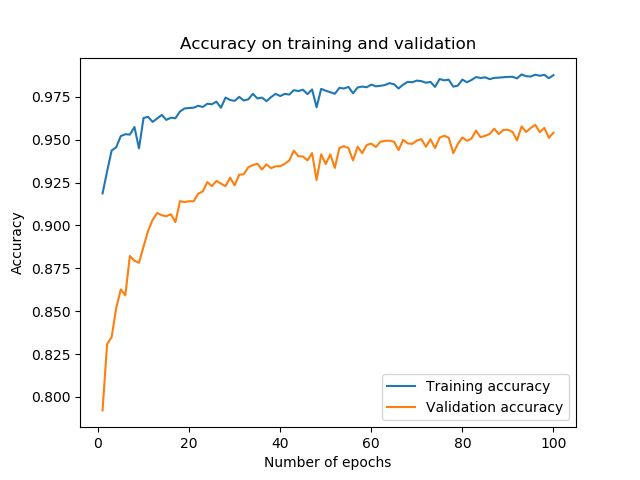

In [4]:
Image('acc_record.png', width=400)

Алгоритм без проблем определяет пол человека, если лицо занимает большую часть фотографии.  
Если же на фото не только лицо, но и плечи, например, точность сильно падает.  
Происходит такое из-за тестового сета, на котором только такой тип фотографий.  
Если нужно распознание не только лиц в упор, в тестовую выборку нужно добавлять и другие типы фотографий. 

Так же для повышения качества модели, можно продолжать ее обучать дальше. Но это будет занимать много времени, а прирост будет небольшой. 